In [6]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import pandas as pd
import numpy as np
import torch
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 1000)
from datetime import datetime
import time
import json
import pytz
utc = pytz.UTC
import random
import datasets
from datasets import ClassLabel
from IPython.display import display, HTML
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm
import evaluate
from sklearn.metrics import accuracy_score, f1_score
from textattack.augmentation import EasyDataAugmenter
from textattack.augmentation import CharSwapAugmenter

In [142]:
devkey = ''

## Acquiring comments

In [204]:
def get_comments(dev_key, video_id, part="snippet", max_results=100):
  youtube = build("youtube", "v3", developerKey=dev_key)

  try:
    response = youtube.commentThreads().list(
        part=part,
        videoId=video_id,
        textFormat="plainText",
        maxResults=max_results,
        order = "relevance"
    ).execute()

    #this gets the top comments Comment threads are ordered by a
    #proprietary YouTube algorithm based on factors like
    #likes, replies, and perceived quality/relevance.

    comments = []
    for item in response["items"]:
      top_level_comment_snippet = item["snippet"]["topLevelComment"]["snippet"]

      comment_text = top_level_comment_snippet["textDisplay"]
      #likes = top_level_comment_snippet["likeCount"]
      published_at = top_level_comment_snippet["publishedAt"]
      published_at = datetime.fromisoformat(published_at.replace('Z', '+00:00'))

      comments.append({
        "comment": comment_text.lower(), #lower case the comments
        #"num_of_likes": likes, #don't need
        "published_at": published_at
      })

    return comments

  except HttpError as error:
      reason = None
      try:
          reason = error.error_details[0]["reason"]
      except:
          pass

      if reason == "commentsDisabled":
          print(f"Skipping video {video_id}: comments are disabled.")
          return []  # return empty list so your pipeline continues

      print(f"Unexpected HTTP error {error.http_status}: {error}")
      return []

In [205]:
def filter_df(df):
  #limit all comments to be between Oct 23rd 2024 and Nov 3rd 2025
  df = df[(df["published_at"] >= utc.localize(datetime(2024, 10, 23))) &
          (df["published_at"] <= utc.localize(datetime(2025, 11, 3)))]


  #limit comments to mentioning zohran
  #function to get zohran's name + only return comments that mention it

  zm = ["zohran", "mamdani"]
  zm_names = "|".join(zm)

  df["zm_mentioned"] = df["comment"].str.contains(zm_names, case=False, na=False)

  return df[df["zm_mentioned"]]

In [206]:
def process_videos(videos: dict, dev_key):
  dfs = []
  for video_id, name in videos.items():
    comments = get_comments(dev_key, video_id = video_id)
    df = pd.DataFrame(comments)
    df.to_csv(name, index=False) #Saving just in case
    filtered = filter_df(df.copy())
    filtered["video"] = name
    filtered["manual_sentiment"] = None
    filtered.drop(["zm_mentioned"], axis=1, inplace=True)
    dfs.append(filtered)
  return pd.concat(dfs, ignore_index=True)

In [207]:
videos = {
    "ot6zbhPLs4Y": "Final_Mayoral_Debate.csv",
    "VNRRqGEqXFs": "Campaign_ad.csv",
    "5q6SKrWtpmU": "Fox_Interview.csv",
    "p2_cRrKScvE": "The_Daily_Show.csv",
    "T7ThzwqHprA": "Hasan_Talk.csv",
    "76BqOb5sklU": "Dave_Rubin.csv",
    "AVfs77NzLa0": "Megyn_Kelly_Commentary.csv",
    "-Z7fPkMTqsg": "Fox_Business.csv",
    "fL9WDCRgX1g": "Sean_Daniel.csv",
    "gJxTWsJdgyo": "New_York_Post.csv",
    "-m544Hwxa7E": "Michael_Knowles.csv",
    "jXaS9Ya6GoI": "John_Stossel.csv",
    "rPUGYY1v0_8": "Fox_Clip.csv",
    "UYREdX6zvB0": "Sky_News.csv",
    "Y_5QN9Rtc-Y": "Steven_Chowder.csv",
    "LOb8COi-7Us": "Newsmax.csv",
    "XSsOWm6cS8g": "NewsNation.csv",
    "HXW3z5G4OdM": "Tom_Bilyeu.csv"
}

In [ ]:
export = process_videos(videos, dev_key = devkey)
export.to_csv("small_set_unclassified.csv")
#i did manual sorting here -> save as small_set.csv

In [208]:
#load and ensure at least 100 positive and 100 negative
small_set = pd.read_csv("small_set.csv", index_col=0)

In [209]:
small_set["manual_sentiment"].value_counts(dropna=False)

,count
manual_sentiment,
1,131
0,108


##  Fine-tuning

In [210]:
small_set = pd.read_csv("small_set.csv", index_col=0)
small_set.drop(['published_at', 'video'], axis = 1, inplace=True)
small_set.rename({'comment': 'text', 'manual_sentiment': 'labels'}, axis = 1, inplace = True)
small_set['labels'] = small_set['labels'].astype('int')
dataset = datasets.Dataset.from_pandas(small_set)
splits = dataset.train_test_split(test_size=0.2, seed=42)

In [211]:
small_set = pd.read_csv("small_set.csv", index_col=0)
len(small_set)

239

In [4]:
#starting with the already fine-tuned model and adding more fine tuning to this specific scenario:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)
encoded_dataset = splits.map(preprocess, batched=True)
encoded_dataset = encoded_dataset.cast_column("labels", ClassLabel(num_classes=2))
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/191 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

In [212]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids

    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

In [7]:
base_model = DistilBertForSequenceClassification.from_pretrained(model_name)

for param in base_model.base_model.parameters():
    param.requires_grad = False

for param in base_model.classifier.parameters():
    param.requires_grad = True

args = TrainingArguments(
    output_dir="output-base",
    report_to="none",
)

base_trainer = Trainer(
    model=base_model,
    args=args,
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [229]:
model1 = DistilBertForSequenceClassification.from_pretrained(model_name)

for param in model1.base_model.parameters():
    param.requires_grad = False

for param in model1.classifier.parameters():
    param.requires_grad = True

args = TrainingArguments(
    output_dir="output",
    learning_rate=1e-4,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    report_to="none",
    logging_steps=10
)

trainer1 = Trainer(
    model=model1,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics
)


trainer1.train()

Step,Training Loss
10,0.605200
20,0.975000
30,0.684000
40,0.666600
50,0.562600
60,0.629900
70,0.516000


TrainOutput(global_step=72, training_loss=0.6609500050544739, metrics={'train_runtime': 662.4779, 'train_samples_per_second': 0.865, 'train_steps_per_second': 0.109, 'total_flos': 61078854697488.0, 'train_loss': 0.6609500050544739, 'epoch': 3.0})

In [ ]:
#going to try data augmentation for the last model
#random insertion, random deletion, random swap

In [9]:
eda_augmenter = EasyDataAugmenter()
char_swap_augmenter = CharSwapAugmenter()
train_df = splits["train"].to_pandas()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
#this takes a while
all_train_text = []
all_train_labels = []
texts = train_df['text'].tolist()
labels = train_df['labels'].tolist()
#i = 0
for text, label in zip(texts, labels):
    #i = i + 1
    #print(i)
    #original
    all_train_text.append(text)
    all_train_labels.append(label)

    # charswap
    aug_char = char_swap_augmenter.augment(text) #returns list of len 1
    all_train_text.append(aug_char[0])
    all_train_labels.append(label)

    # random insert/delete
    aug_eda_list = eda_augmenter.augment(text)
    all_train_text.extend(aug_eda_list)
    all_train_labels.extend([label] * len(aug_eda_list))

In [15]:
augmented_df = pd.DataFrame({
    "text": all_train_text,
    "label": all_train_labels
})
augmented_df.to_csv('Augmented_train.csv')

In [16]:
augmented_df = pd.read_csv('Augmented_train.csv')
augmented_dataset = datasets.Dataset.from_pandas(augmented_df)
augmented_dataset = augmented_dataset.rename_column("label", "labels")
augmented_dataset

Dataset({
    features: ['Unnamed: 0', 'text', 'labels'],
    num_rows: 1144
})

In [17]:
def aug_preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

In [14]:
encoded_aug_dataset = augmented_dataset.map(aug_preprocess, batched=True)
encoded_aug_dataset = encoded_aug_dataset.cast_column("labels", ClassLabel(num_classes=2))
encoded_aug_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1144 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1144 [00:00<?, ? examples/s]

In [18]:
model2 = DistilBertForSequenceClassification.from_pretrained(model_name)

for param in model2.base_model.parameters():
    param.requires_grad = False

for param in model2.classifier.parameters():
    param.requires_grad = True

args = TrainingArguments(
    output_dir="output",
    learning_rate=1e-4,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    report_to="none",
    logging_steps=50
)

trainer2 = Trainer(
    model=model2,
    args=args,
    train_dataset=encoded_aug_dataset,
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics
)


trainer2.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Step,Training Loss
50,0.783300
100,0.580000
150,0.561100
200,0.531900


TrainOutput(global_step=216, training_loss=0.6102581730595341, metrics={'train_runtime': 5061.4768, 'train_samples_per_second': 0.678, 'train_steps_per_second': 0.043, 'total_flos': 454628112187392.0, 'train_loss': 0.6102581730595341, 'epoch': 3.0})

## Model Comparision

In [244]:
base_result = base_trainer.evaluate()
print("Base Model: ", base_result)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Base Model:  {'eval_loss': 1.0963194370269775, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.7291666666666666, 'eval_f1': 0.7297608600263273, 'eval_runtime': 10.067, 'eval_samples_per_second': 4.768, 'eval_steps_per_second': 0.596}


In [231]:
res1 = trainer1.evaluate()
print("Fine-Tuned Model: ", res1)

Fine-Tuned Model:  {'eval_loss': 0.48216569423675537, 'eval_accuracy': 0.7708333333333334, 'eval_f1': 0.7680499325236166, 'eval_runtime': 8.6879, 'eval_samples_per_second': 5.525, 'eval_steps_per_second': 0.691, 'epoch': 3.0}


In [20]:
res2 = trainer2.evaluate()
print("Fine-Tuned Model with Data Augmentation: ", res2)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine-Tuned Model with Data Augmentation:  {'eval_loss': 0.4617667496204376, 'eval_accuracy': 0.8125, 'eval_f1': 0.8102226720647773, 'eval_runtime': 20.3719, 'eval_samples_per_second': 2.356, 'eval_steps_per_second': 0.147, 'epoch': 3.0}


In [55]:
val = encoded_dataset["test"]
base_preds = base_trainer.predict(val)
base_labels = np.argmax(base_preds.predictions, axis=1)
aug_preds  = trainer2.predict(val)
aug_labels = np.argmax(aug_preds.predictions, axis=1)
true_labels = val["labels"] #true labels

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [70]:
comp_df = pd.DataFrame({
    "Comment": splits["test"],
    "Base_Prediction": base_labels,
    "Finetuned_Prediction": aug_labels,
    "True_Sentiment": true_labels
})

In [72]:
changes = comp_df[comp_df["Base_Prediction"] != comp_df["Finetuned_Prediction"]]
changes

,Comment,Base_Prediction,Finetuned_Prediction,True_Sentiment
0,"{'text': 'dont be complacent go vote zohran yall, man of the people', 'labels': 1, '__index_level_0__': 75}",0,1,tensor(1)
1,"{'text': 'pathetic cuomo couldn’t even take the time to shake the hands of his opponents. runs to the moderators and then scurries away. zohran and curtis did immediately.', 'labels': 1, '__index_level_0__': 3}",0,1,tensor(1)
7,"{'text': 'there was a lot of planning and effort in the failed 1993 wtc bombing. but with mamdani as mayor, they’ll just be able to walk right in to the stock exchange - no questions asked.', 'labels': 0, '__index_level_0__': 196}",1,0,tensor(0)
8,"{'text': 'trump calling mamdani communist, but trump's father-in-law was a member of communist party, an active member.first lady's father was a communist😅', 'labels': 1, '__index_level_0__': 134}",0,1,tensor(1)
11,"{'text': 'mamdani is not an islamist. no policy he has articulated has anything to do with islam.', 'labels': 1, '__index_level_0__': 130}",0,1,tensor(1)
46,"{'text': 'read more: https://www.foxnews.com/politics/zohran-mamdani-says-nyc-should-uphold-icc-arrest-warrant-netanyahu-he-visits-city', 'labels': 0, '__index_level_0__': 24}",0,1,tensor(0)


In [ ]:
#save only the best performing model

In [19]:
trainer2.save_model("zm-sentiment-model")
tokenizer.save_pretrained("zm-sentiment-model")

('zm-sentiment-model/tokenizer_config.json',
 'zm-sentiment-model/special_tokens_map.json',
 'zm-sentiment-model/vocab.txt',
 'zm-sentiment-model/added_tokens.json')

## Acquiring more comments

In [ ]:
#track changes in specific channels: Fox News, CNN, BreakingPoints
#YouTube Data API v3 work around to get all channel videos

In [213]:
def get_all_channel_videos(channel_id, dev_key):
    youtube = build("youtube", "v3", developerKey=dev_key)


    channel = youtube.channels().list(
        part="contentDetails",
        id=channel_id
      ).execute()

    playlist_id = channel["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

    videos = []
    next_page_token = None
    while True:
        response = youtube.playlistItems().list(
            part="snippet",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()

        for item in response["items"]:
            snippet = item["snippet"]
            published_at = datetime.fromisoformat(snippet["publishedAt"].replace("Z", "+00:00"))

            # filter to only include dates in range
            if published_at < utc.localize(datetime(2024, 10, 23)):
                continue
            if published_at >  utc.localize(datetime(2025, 11, 3)):
                continue

            videos.append({
                "video_id": snippet["resourceId"]["videoId"],
                "video_name": snippet["title"],
                "channel_name": snippet["channelTitle"],
                "published_at": published_at.isoformat()
            })

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos

In [214]:
def process_new_videos(videos, dev_key, verbose=False):
  dfs = []
  #for video_id, video_name, channel_name in videos.items():
  i = 0
  for video in videos:
    i = i + 1
    comments = get_comments(video_id = video["video_id"], dev_key=dev_key)
    df = pd.DataFrame(comments) #if this is empty, skip rest of steps
    if len(df) == 0:
      continue
    filtered = filter_df(df.copy())
    filtered.drop(["zm_mentioned"], axis=1, inplace=True)
    filtered["video"] = video["video_name"]
    filtered["channel"] = video["channel_name"]
    dfs.append(filtered)
    if verbose:
      print("video ", i, " processed of ", len(videos))

    if i % 1000 == 0:
      df_mid = pd.concat(dfs, ignore_index=True)
      df_mid.to_csv(video["channel_name"]+str(i)+'.csv')


  return pd.concat(dfs, ignore_index=True)

In [ ]:
channels = {
    "UCDRIjKy6eZOvKtOELtTdeUA": "breaking_points.csv",
    "UCupvZG-5ko_eiXAupbDfxWw": "CNN.csv",
    "UCXIJgqnII2ZOINSWNOGFThA": "Fox_News.csv"
}

#for channel_id in channel_ids:
for channel_id, name in channels.items():
  channel_videos = get_all_channel_videos(channel_id, dev_key = devkey)
  print("retrived ", len(channel_videos), " channel videos within date range")
  df = process_new_videos(channel_videos, dev_key = devkey)
  #df of comments from one channel
  df.to_csv(name, index=False)
  print("saved channel comments in CSV")

#these had to be run separetly
#saved channel_videos -> json
#loaded json and ran on subsets to avoid API quota

## Classify large dataset with best model

In [216]:
cnn = pd.read_csv('CNN.csv')
fox = pd.read_csv('Fox_News.csv')
bp = pd.read_csv('breaking_points.csv')
dfs = [cnn, fox, bp]

df_full = pd.concat(dfs, ignore_index=True)

In [24]:
pipe = pipeline(
    "sentiment-analysis",
    model="zm-sentiment-model",
    tokenizer="zm-sentiment-model",
    truncation=True,
    batch_size=64,
    device_map="auto"
)

texts = df_full['comment'].tolist()

results = []
for i in tqdm(range(0, len(texts), 64), desc="Sentiment Analysis"):
    batch = texts[i:i+64]
    batch_out = pipe(batch)
    results.extend(batch_out)

df_full['sentiment'] = [1 if r['label'] == 'POSITIVE' else 0 for r in results]
#this takes about a half hour

Device set to use cpu
Sentiment Analysis: 100%|██████████| 81/81 [33:54<00:00, 25.12s/it]


In [25]:
df_full.to_csv('Comment_Sentiments.csv')

## Analysis over time

In [184]:
df = pd.read_csv('Comment_Sentiments.csv')

In [185]:
len(df)

5134

In [186]:
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)
df['published_at'] = pd.to_datetime(df['published_at'])

In [187]:
cnn = df[df['channel'] == 'CNN']
fox = df[df['channel'] == 'Fox News']
bp = df[df['channel'] == 'Breaking Points']

In [188]:
def agg(df, period):
  df['pub'] = df['published_at'].dt.tz_localize(None).dt.to_period(period)
  agg = (
    df.assign(period=df['pub'])
      .groupby('period')['sentiment']
      .agg(
          count='count',
          prop_positive=lambda x: (x == 1).mean()
      )
      .reset_index()
  )
  agg['period'] = agg['period'].dt.to_timestamp()
  return agg

In [189]:
cnn_weekly = agg(cnn.copy(), 'W')
fox_weekly = agg(fox.copy(), 'W')
bp_weekly = agg(bp.copy(), 'W')

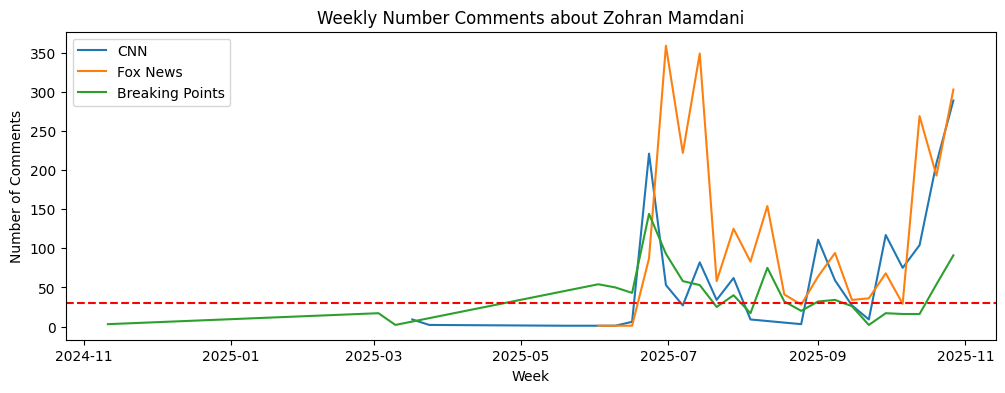

In [203]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x="period", y="count", data=cnn_weekly, label="CNN")
sns.lineplot(x="period", y="count", data=fox_weekly, label="Fox News")
sns.lineplot(x="period", y="count", data=bp_weekly, label="Breaking Points")

ax.axhline(30, color="red", linestyle="--", linewidth=1.5)


plt.xlabel("Week")
plt.ylabel("Number of Comments")
plt.title("Weekly Number Comments about Zohran Mamdani")
plt.legend()
plt.show()
fig.savefig("num_comments.png", dpi=300, bbox_inches='tight')

In [191]:
cnn_daily = agg(cnn.copy(), 'D')
fox_daily = agg(fox.copy(), 'D')
bp_daily = agg(bp.copy(), 'D')

In [192]:
cnn_daily['prop_positive_7d'] = cnn_daily['prop_positive'].rolling(7, min_periods=1).mean()
fox_daily['prop_positive_7d'] = fox_daily['prop_positive'].rolling(7, min_periods=1).mean()
bp_daily['prop_positive_7d'] = bp_daily['prop_positive'].rolling(7, min_periods=1).mean()

In [193]:
day_cutoff = datetime.strptime("2025-06-16", "%Y-%m-%d")
bp_daily = bp_daily[bp_daily['period'] >= day_cutoff]
cnn_daily = cnn_daily[cnn_daily['period'] >= day_cutoff]
fox_daily = fox_daily[fox_daily['period'] >= day_cutoff]

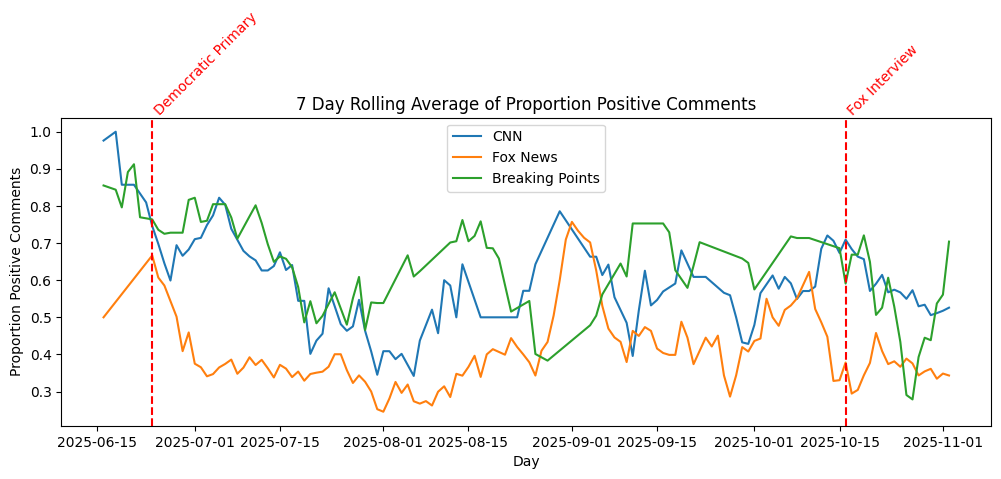

In [202]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x="period", y="prop_positive_7d", data=cnn_daily, label="CNN")
sns.lineplot(x="period", y="prop_positive_7d", data=fox_daily, label="Fox News")
sns.lineplot(x="period", y="prop_positive_7d", data=bp_daily, label="Breaking Points")

vline_date = "2025-06-24"
ax.axvline(pd.to_datetime(vline_date), color="red", linestyle="--", linewidth=1.5)
ax.text(pd.to_datetime(vline_date), ax.get_ylim()[1], "Democratic Primary",
        rotation=45, verticalalignment="bottom", color="red")

vline_date = "2025-10-16"
ax.axvline(pd.to_datetime(vline_date), color="red", linestyle="--", linewidth=1.5)
ax.text(pd.to_datetime(vline_date), ax.get_ylim()[1], "Fox Interview",
        rotation=45, verticalalignment="bottom", color="red")


plt.xlabel("Day")
plt.ylabel("Proportion Positive Comments")
plt.title("7 Day Rolling Average of Proportion Positive Comments")
plt.legend()
plt.show()
fig.savefig("prop_pos.png", dpi=300, bbox_inches='tight')
#plt.savefig("prop_pos.png", dpi=300, bbox_inches='tight')


In [106]:
#issue: says whether sentiment is negative, not necessarily sentiment TOWARDS mamdani
df.iloc[[4250, 4594]]

,comment,published_at,video,channel,sentiment
4250,the amount of hostility zohran mamdani has received from both the right and the left because he wants to help working class american people who are struggling is disgusting!! the billionaires are supposed to pick our leaders?? the voters don't get to choose their leaders in the usa?,2025-10-22 20:10:49+00:00,Trump LASHES OUT At 'Ugandan Communist' Zohran,Breaking Points,0
4594,"cuomo lost cuz mamdani wants to help new yorkers, cuomo wants to help himself. gee. tough call.",2025-07-22 17:50:20+00:00,LEAKED: Cuomo Admits Jews OVERWHEMLINGLY Pro-Zohran,Breaking Points,0
